# What's really going on in PBjam - an advanced tutorial

## Introduction

PBjam is a code for 'peakbagging' solar-like oscillations.  The code has been designed to provide automated peakbagging data analysis relying on probablilistic methods.  The aim is to achieve a peakbagging code that will work, and not just on high signal-to-noise targets but also on lower signal-to-noise examples.  We aim to achieve a code that works on a wide variety of solar-like oscillations including main sequence, sub giant, and red giant stars.  And we aim to provide all this functionality in an easy to use interface that requires little user expertise.

The current state of PBjam reflects it's developmental nature.  Currently functionality is provided for peakbagging radial and quadrupole modes.  Additional functionality for dipole and octupole modes is under developement and will be released as part of version 2.0. 

In this example we will demonstrate what is happening under the hood of PBjam.  As such this consititutes an advanced tutorial that relies somewhat on basic knowledge of solar-like peakbaggin and it's terminology.  There are many resouces in the scientific literature if the user requires more background (link Guy, Martin papers). 

This example will look at a high signal-to-noise ratio red giant with nearly 4 years of high quality Kepler data (KIC 4448777).  We will use the excellent Lightkurve tool to handle the data and refer the user to the excellent Lightkurve docs for details and functionality.

In [2]:
import pbjam as pb
import lightkurve as lk 

KIC 4448777 has already been extensively studied and the interested reader can find more [here](https://ui.adsabs.harvard.edu/abs/2016ApJ...817...65D/abstract).  Table 2 of this work lists mode frequencies that we can use as a comparison with our results later.

## Setup

We start by setting up the exisiting knowledge of the star.  We take exisiting values of $\nu_{\rm max}$, $\Delta {\nu}$, Teff, and Gaia $G_{\rm bp} - G_{\rm rp}$.  Each observable is set up as a tuple in the form (value, ucertainty).  

We will use all four of the observed quantities but PBjam can be run with some subset of the observables.  It is recommended that as an absolute minimum, at least $\nu_{\rm max}$ and $\Delta {\nu}$ should be provided for rediants and subgiants, while at least $\Delta {\nu}$ and Teff should be provided for main sequence stars.  PBjam will work best if all 4 observed properties are provided and the provided values are accurate.

In [17]:
kic = '4448777'
numax = (220.0, 3.0)
dnu = (16.97, 0.05)
teff = (4750, 250)
bp_rp = (1.34, 0.1)

### Data collection and preparation

We handle all of our data in this tutorial using [lightkurve](https://docs.lightkurve.org/index.html).  First we download all available lightcurves:

In [14]:
lcs = lk.search_lightcurvefile(kic).download_all()

We then process the lightcurve collection by concatenating, normalizing, flattening, and the finally removing outliers:

In [15]:
lc = lcs[0].PDCSAP_FLUX.normalize().flatten(window_length=401)
for l in lcs[1:]:
    lc = lc.append(l.PDCSAP_FLUX.normalize().flatten(window_length=401))
lc = lc.remove_outliers(4)

Lightkurve provides plot functionality for it's lightcurve objects and so to plot the time series data we simply:

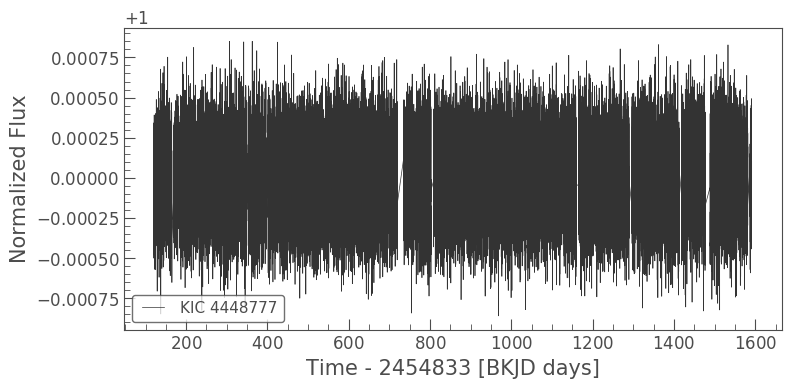

In [16]:
lc.plot();

We then use the lightkurve periodogram functionality to get a critically sampled power spectrum with frequency units of $\mu \rm Hz$ (i.e., normalization='psd').  We set the maximum and minimum frequency of the periodogram based on the estimated numax and dnu and finally we flatten the periodogram.

The flatten function uses lightkurves inbuilt method to remove the broadband background power but maintain the modes of oscillation.  The lightkurve method uses a simple estimation of the background based on a varying width median filter and divides the power by the estimated background to produce what is commonly referred to as a signal-to-noise spectrum.  The lightkurve implementation is less than optimal but fast and easy to use.  If you care about the treatment of the background and worry about it's impact on your results then you can implement your own method here (for example background fitting) to produce a flattened periodogram.

In [24]:
pg = lc.to_periodogram(normalization='psd', 
                      minimum_frequency=numax[0] - dnu[0] * 4,
                      maximum_frequency=numax[0] + dnu[0] * 4).flatten()

Again, a lightkurve periodogram has a plot function:

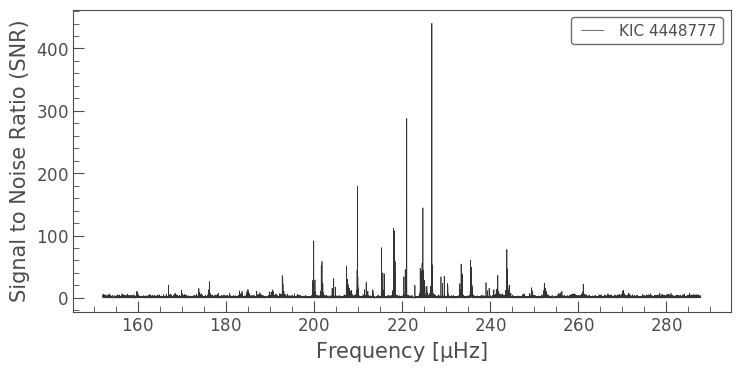

In [25]:
pg.plot()

At this stage our setup is complete.  We have some observed properties and we have some data.  We move on to using PBjam to tru to understand the data we have.

## PBjamming

### Motivation



In [ ]:
ep = pb.epsilon()
result = ep(dnu=dnu, numax=numax, teff=teff, bp_rp=bp_rp, bw_fac=1.0)

In [ ]:
ep.plot_corner();

In [ ]:
ep.plot(pg);

In [18]:
asy = pb.asy_peakbag.asymptotic_fit(pg.frequency.value, pg.power.value, 
                                    ep.samples, 
                                    teff, bp_rp, 
                                    nthreads=1, norders=10,
                                    store_chains=True)

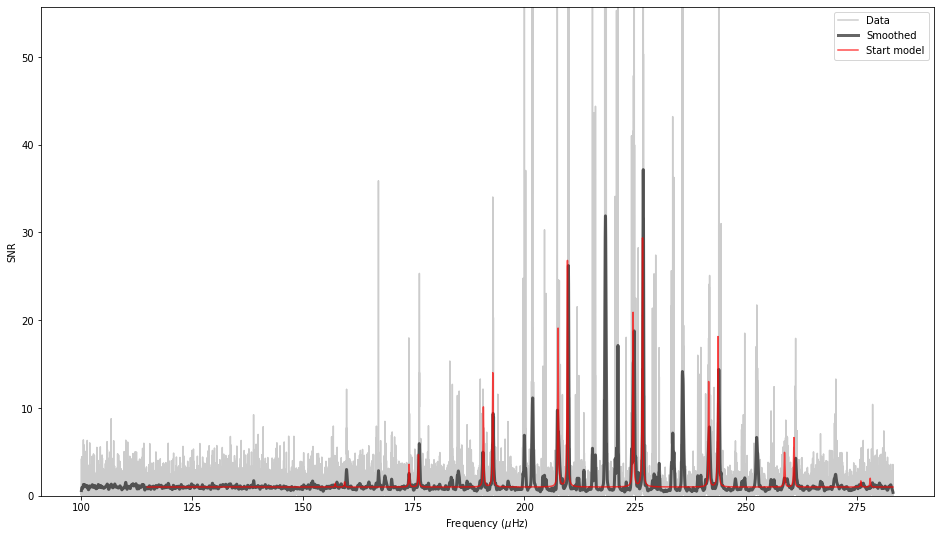

In [19]:
asy.plot_start();

In [20]:
asy_result = asy.run(burnin=1000, niter=1000)

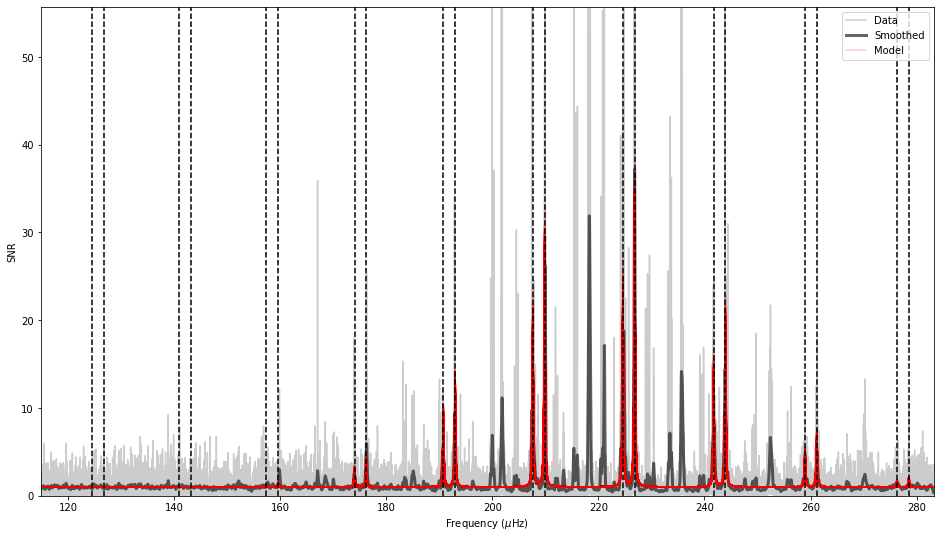

In [21]:
asy.plot();

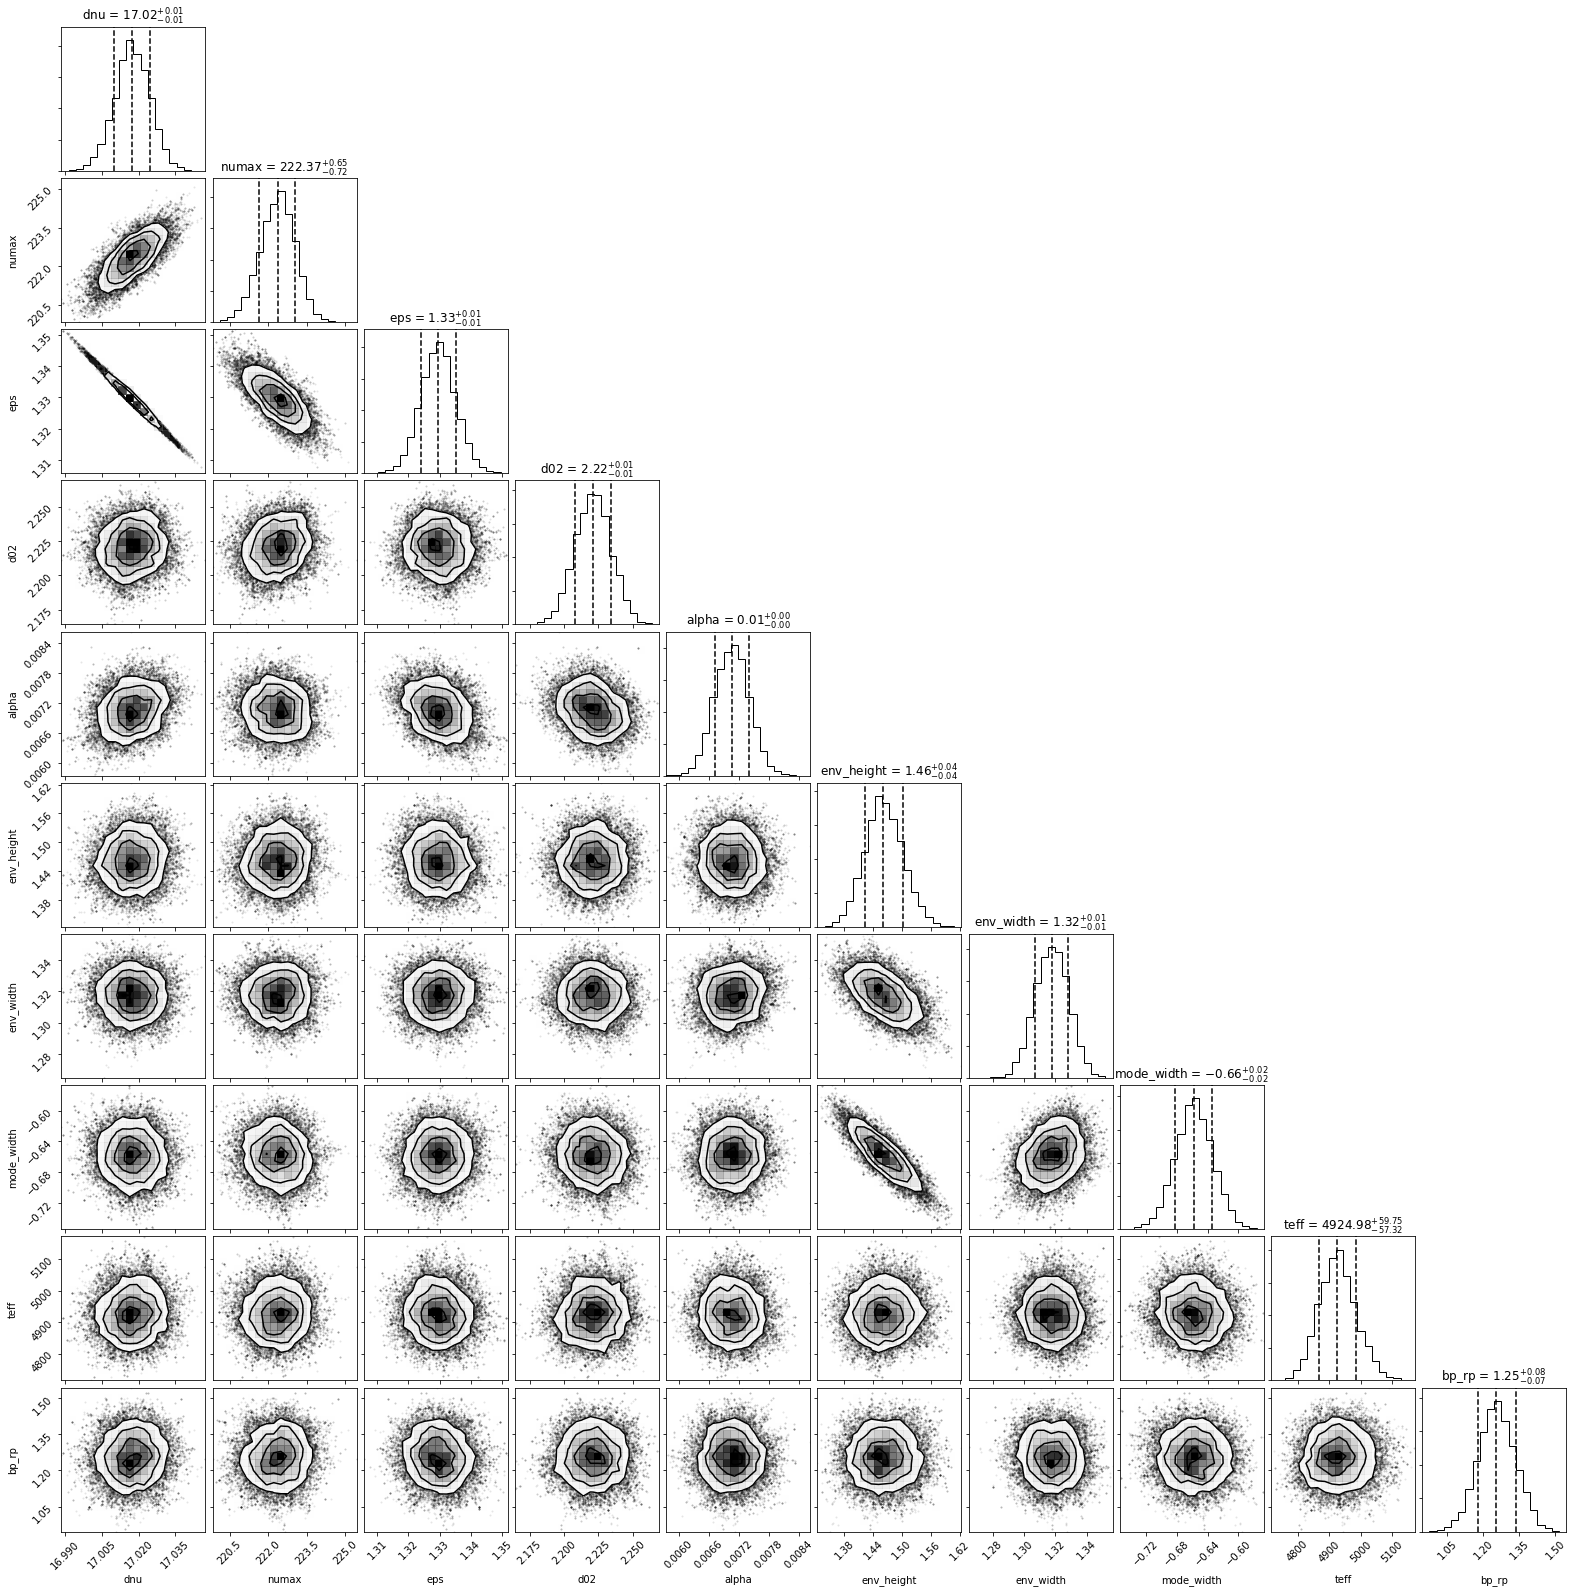

In [22]:
asy.plot_corner();

In [23]:
import pbjam
import importlib
importlib.reload(pbjam)
pbag = pbjam.peakbag(pg.frequency.value, pg.power.value, asy_result)

In [24]:
import pickle

edict = {'f': pg.frequency.value, 'p': pg.power.value, 'a': asy_result}

pickle_out = open("pb.pickle","wb")
pickle.dump(edict, pickle_out)
pickle_out.close()

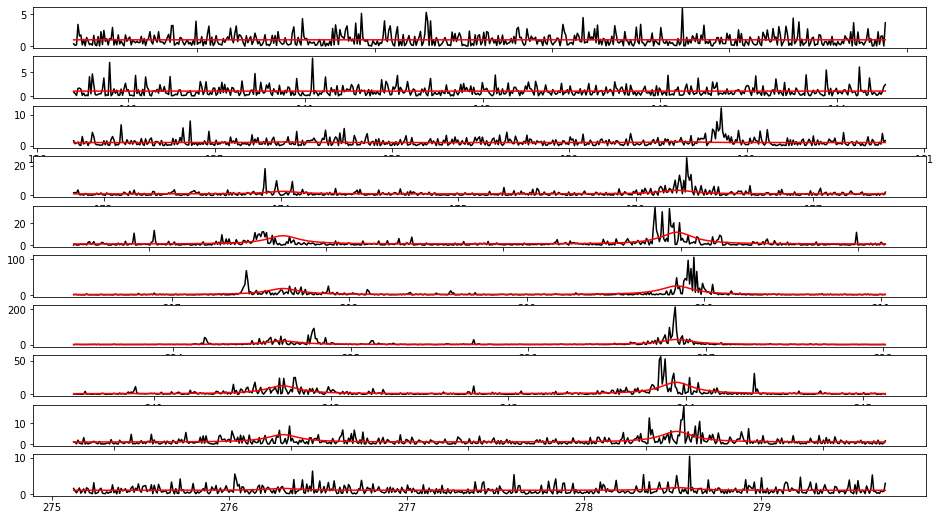

In [25]:
pbag.plot_start_model();

In [26]:
pbag.sample(model_type='simple', cores=4, tune=1500)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [back, height2, height0, width2, width0, l2, l0]
Sampling 4 chains: 100%|██████████| 8000/8000 [07:14<00:00,  6.72draws/s]
The acceptance probability does not match the target. It is 0.8844754933579762, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [back, height2, height0, width2, width0, l2, l0]
Sampling 4 chains:   1%|          | 79/14000 [00:03<10:28, 22.16draws/s]


ValueError: Not enough samples to build a trace.

In [ ]:
pbag.plot_fit(thin=1);